# Preprocessing B984

This notebook visualizes and compiles the input data for the combined retrieval from flight B984.

In [1]:
%load_ext autoreload
%autoreload 2
from joint_flight.notebook import *
from joint_flight import plot_observations
from joint_flight.data.b984 import *

No environment variable JOINT_FLIGHT_PATH found. Will look in /home/simonpf/src/joint_flightfor the joint flight data.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/simonpf/build/anaconda3/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'dbz' has multiple fill values {-888.0, -999.0}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/home/simonpf/build/anaconda3/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'ldr' has multiple fill values {-888.0, -999.0}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/home/simonpf/build/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:1026: RuntimeWarning: overflow encountered in add
  result = self.f(da, db, *args, **kwargs)


## Overview

Generate overview of observations.

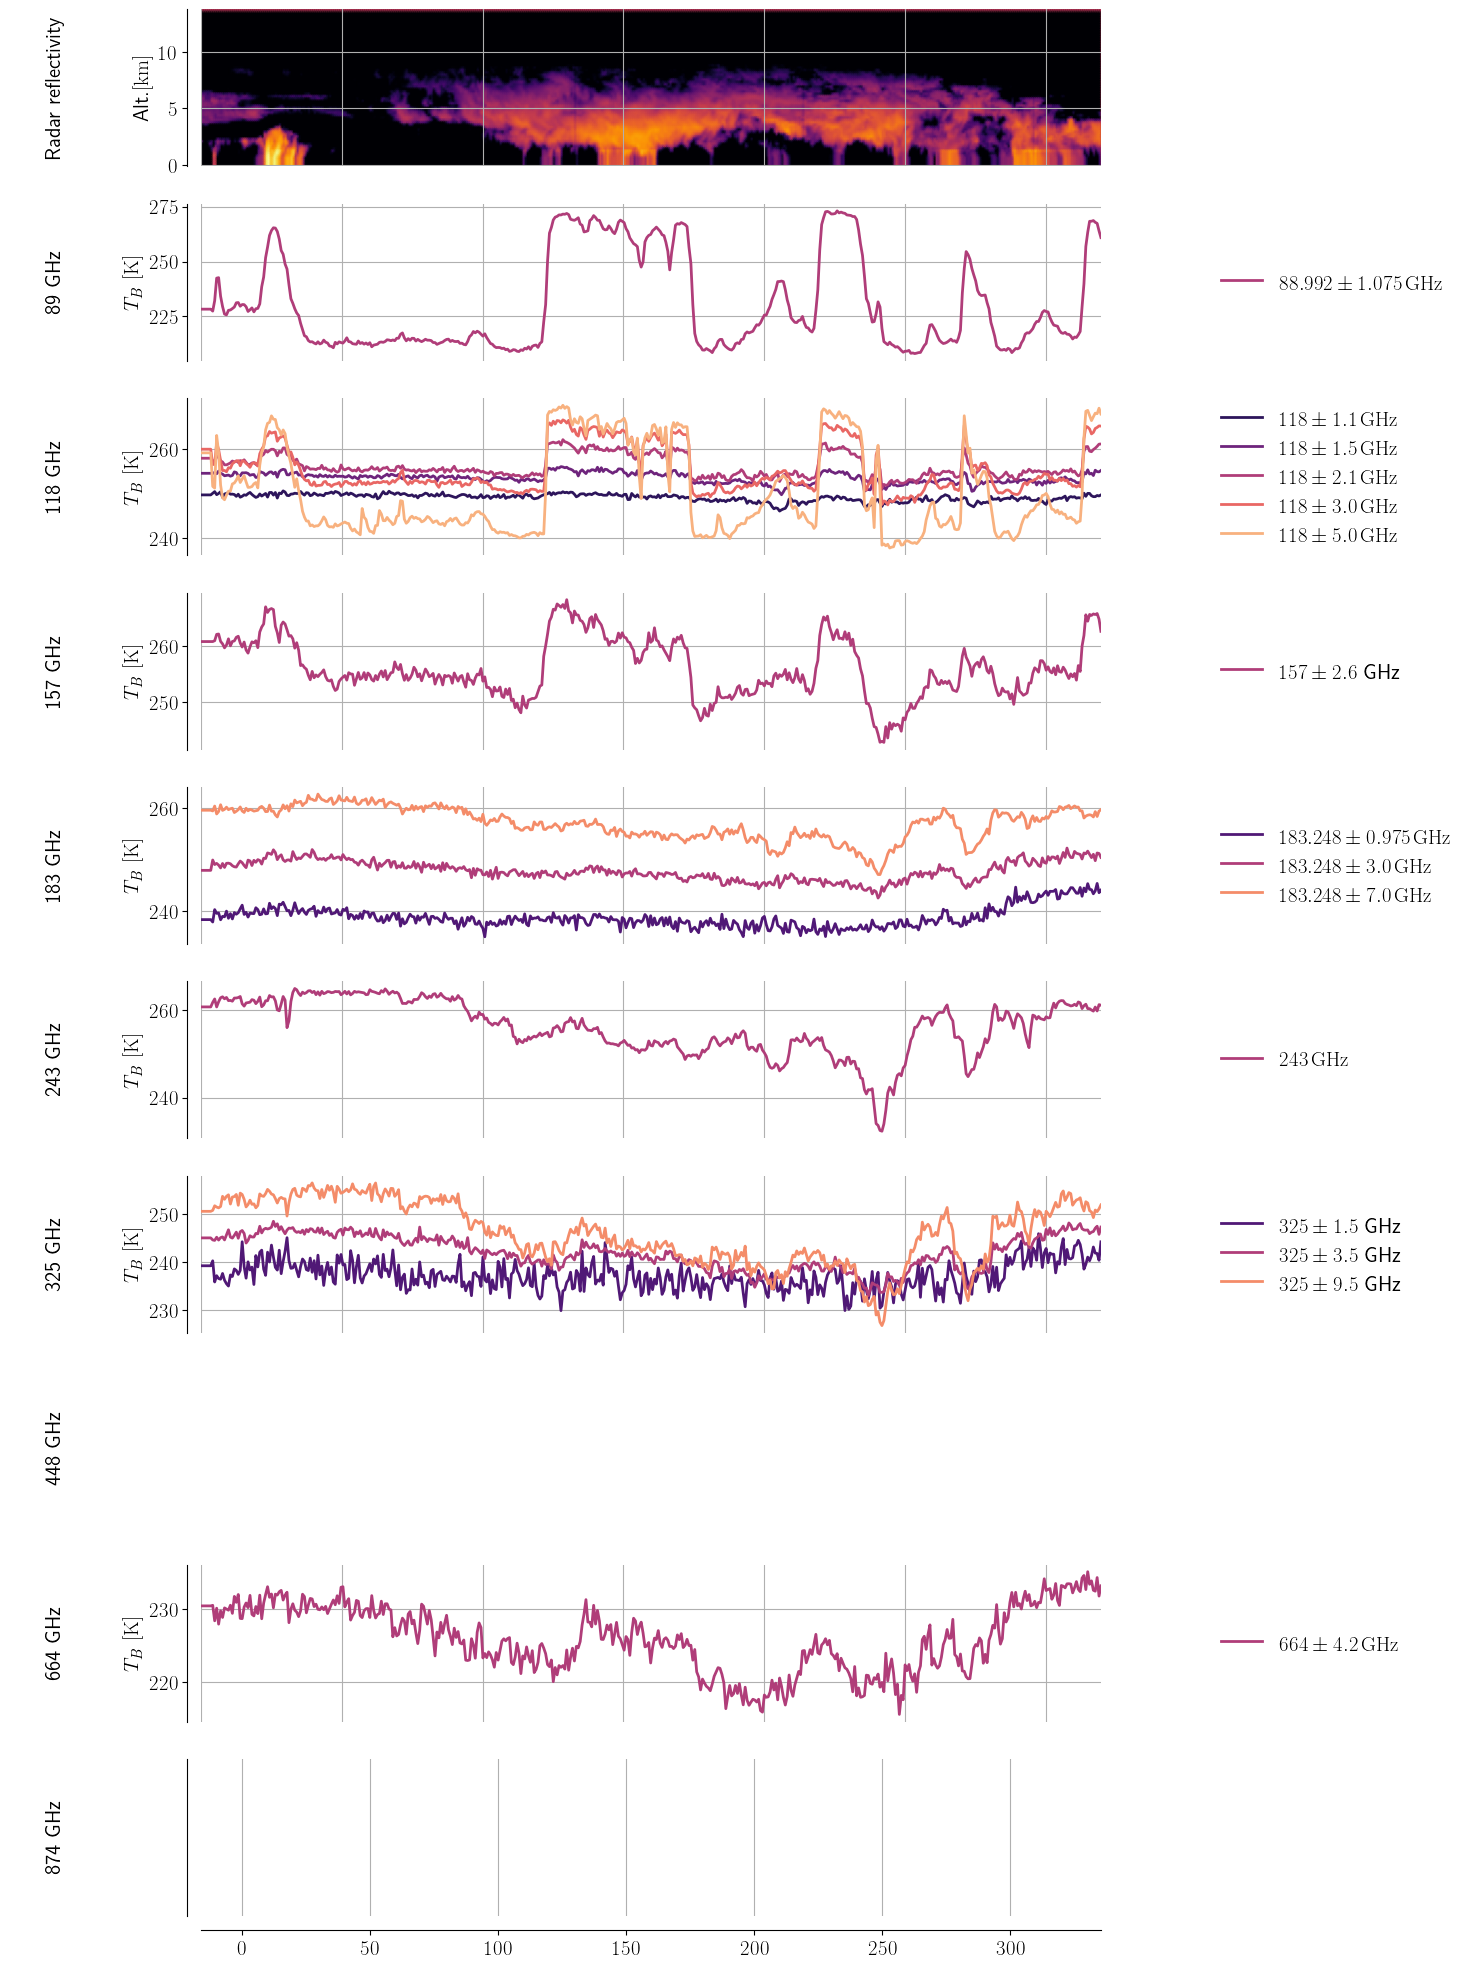

In [2]:
from matplotlib.gridspec import GridSpec
plt.style.use("../misc/matplotlib_style.rc")
f = plt.figure(figsize=(15, 20))
gs = GridSpec(10, 3, width_ratios=[0.1, 1.0, 0.1])
axs = [f.add_subplot(gs[i, 1]) for i in range(10)]
legends = [f.add_subplot(gs[i, 2]) for i in range(10)]
names = [f.add_subplot(gs[i, 0]) for i in range(10)]


plot_observations(
    ISMAR, MARSS, RADAR, axs=axs,
    legends=legends,
    missing_channels=[14, 15, 16, 20],
    names=names
)
plt.show()

## Atmospheric background

In [3]:
ATMOSPHERE

<xarray.Dataset>
Dimensions:                  (observations: 470, levels: 65)
Dimensions without coordinates: observations, levels
Data variables:
    pressure                 (observations, levels) float64 1e+05 ... 1.498e+04
    temperature              (observations, levels) float64 282.9 ... 220.8
    relative_humidity        (observations, levels) float64 0.8625 ... 0.02715
    water_vapor              (observations, levels) float64 0.01042 ... 5.31e-06
    oxygen                   (observations, levels) float64 0.2091 ... 0.2092
    ozone                    (observations, levels) float64 2.905e-08 ... 9.9...
    nitrogen                 (observations, levels) float64 0.7814 ... 0.7816
    cloud_water              (observations, levels) float64 0.0 ... 0.0
    u10                      (observations) float64 -12.67 -12.68 ... -9.121
    v10                      (observations) float64 2.955 2.972 ... -0.8049
    sea_surface_temperature  (observations) float64 285.2 285.2 ... 286.5 286.5
    skin_temperature         (observations) float64 285.2 285.3 ... 286.4 286.4

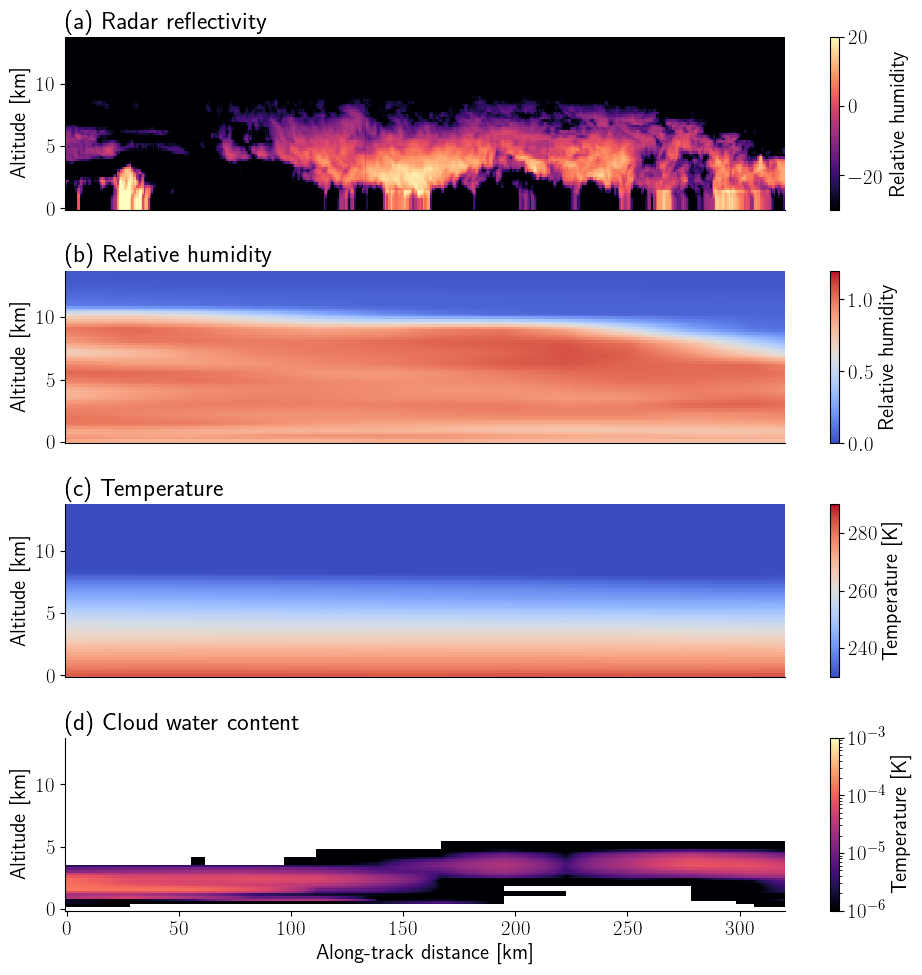

array([<AxesSubplot:title={'left':'(a) Radar reflectivity'}, ylabel='Altitude [km]'>,
       <AxesSubplot:title={'left':'(b) Relative humidity'}, ylabel='Altitude [km]'>,
       <AxesSubplot:title={'left':'(c) Temperature'}, ylabel='Altitude [km]'>,
       <AxesSubplot:title={'left':'(d) Cloud water content'}, xlabel='Along-track distance [km]', ylabel='Altitude [km]'>],
      dtype=object)

In [4]:
from joint_flight import plot_atmosphere
from matplotlib.colors import Normalize, LogNorm

plot_atmosphere(RADAR, ATMOSPHERE)

# Obsrvations
## MARSS

In [5]:
from matplotlib.colors import Normalize

def plot_channels(data, names):
    f, axs = plt.subplots(2, 1)
    
    x = RADAR.d / 1e3
    x_min = x.min()
    x_max = x.max()
    
    ax = axs[0]
    for d, n in zip(data, names):
        ax.plot(x, d, label=n)
    ax.legend(bbox_to_anchor=[1.0, 0.5])
    ax.set_xlim([x_min, x_max])
        
    ax = axs[1]
    y = RADAR.y
    x = RADAR.x / 1e3
    dbz = RADAR.dbz
    
    ax.pcolormesh(x, y / 1e3, dbz, norm=Normalize(-20, 20))
    ax.set_ylim(0, 11)
    ax.set_xlim([x_min, x_max])
    plt.show()

In [6]:
MARSS

<xarray.Dataset>
Dimensions:                  (rays: 470, channel: 5)
Coordinates:
  * channel                  (channel) |S9 b'M16-89' b'M17-157' ... b'M20-183+7'
Dimensions without coordinates: rays
Data variables:
    latitude                 (rays) float32 59.47 59.47 59.47 ... 56.64 56.63
    longitude                (rays) float32 -6.504 -6.504 -6.504 ... -6.5 -6.5
    brightness_temperatures  (rays, channel) float32 228.3 260.8 ... 250.4 259.6
    errors                   (rays, channel) float32 0.1734 0.01507 ... 0.04903
    altitude                 (rays) float32 9.451e+03 9.451e+03 ... 9.353e+03
    time                     (rays) datetime64[ns] 2016-10-14T09:48:50.800781...

In [7]:
n_rays = RADAR.d.size
y_marss = np.zeros((n_rays, 5))
y_marss_nedt = np.zeros((n_rays, 5))
tbs_marss = MARSS["brightness_temperatures"]
errors_marss = MARSS["errors"]

### 89 GHz

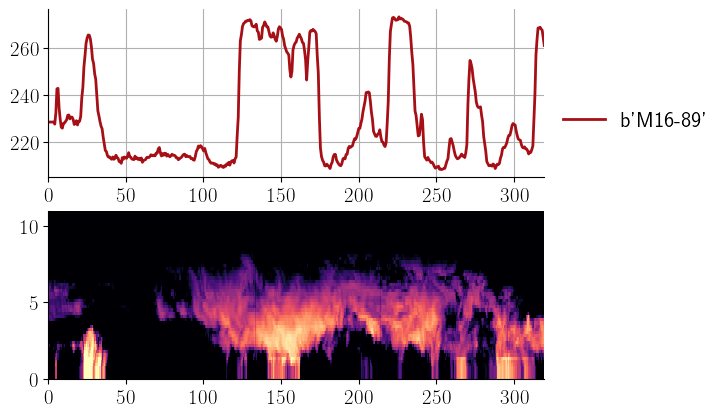

In [8]:
data = [
    tbs_marss[:, 0],
]
names = map(lambda x: x.data, MARSS.channel[:1])
plot_channels(data, names)

In [9]:
y_marss[:, 0] = tbs_marss[:, 0]
y_marss_nedt[:, 0] = errors_marss[:, 0] + 1e6 * SURFACE_MASK.data

### 157 GHz

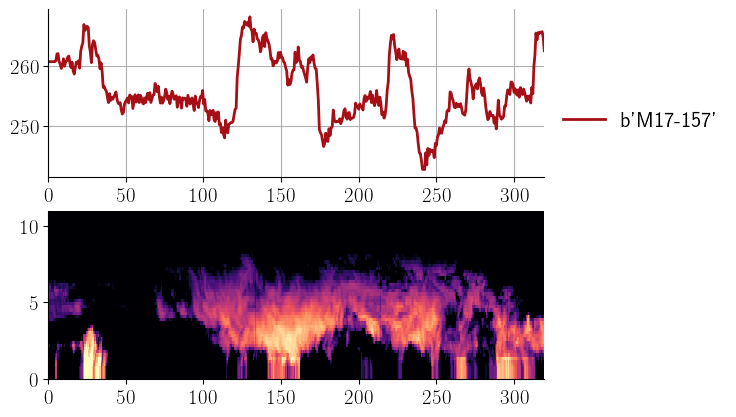

In [10]:
data = [
    tbs_marss[:, 1],
]
names = map(lambda x: x.data, MARSS.channel[1:2])
plot_channels(data, names)

In [11]:
y_marss[:, 1] = tbs_marss[:, 1]
y_marss_nedt[:, 1] = errors_marss[:, 1] + 1e6 * SURFACE_MASK.data

### 183 GHz

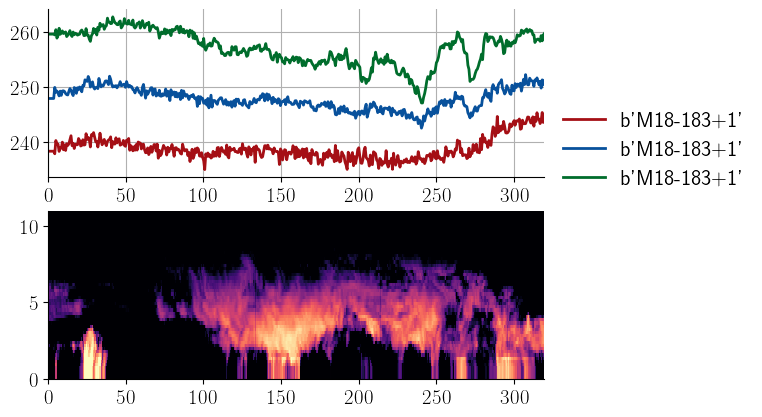

In [12]:
data = [
    tbs_marss[:, 2:],
]
names = map(lambda x: x.data, MARSS.channel[2:])
plot_channels(data, names)

In [13]:
y_marss[:, 2:] = tbs_marss[:, 2:]
y_marss_nedt[:, 2:] = errors_marss[:, 2:]

## ISMAR

In [14]:
y_ismar = np.zeros((n_rays, 10))
y_ismar_nedt = np.zeros((n_rays, 10))
tbs_ismar = ISMAR.brightness_temperatures.data
errors_ismar = ISMAR.errors.data

### 118 GHz

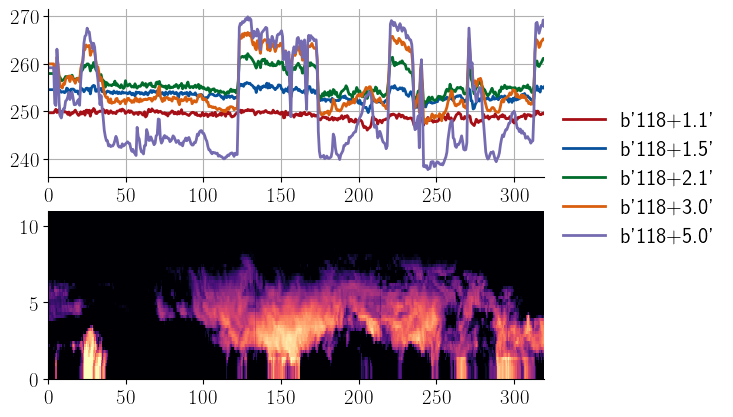

In [15]:
data = [
    tbs_ismar[:, 0],
    tbs_ismar[:, 1],
    tbs_ismar[:, 2],
    tbs_ismar[:, 3],
    tbs_ismar[:, 4],
]
names = map(lambda x: x.data, ISMAR.channel[:5])
plot_channels(data, names)

In [16]:
y_ismar[:, :5] = tbs_ismar[:, :5]
y_ismar_nedt[:, :5] = errors_ismar[:, :5]
y_ismar_nedt[:, 1:5] += SURFACE_MASK.data.reshape(-1, 1) * 1e6

### 243 GHz

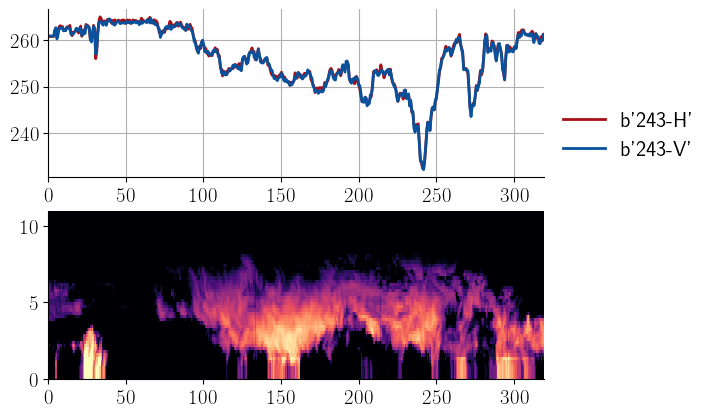

In [17]:
data = [
    tbs_ismar[:, 5],
    tbs_ismar[:, 6]
]
names = map(lambda x: x.data, ISMAR.channel[5:7])
plot_channels(data, names)

### 243 GHz - 30$^\circ$

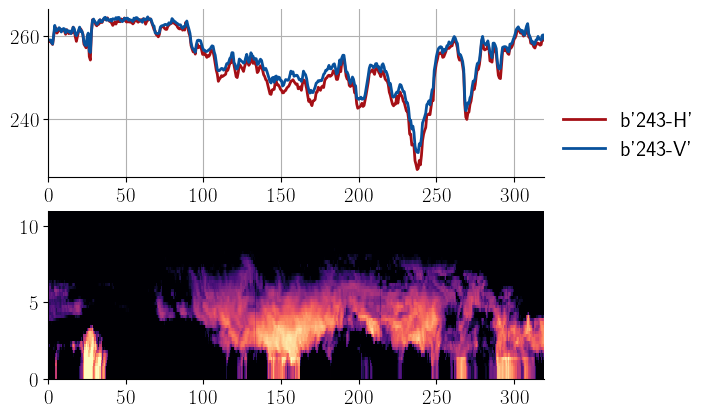

In [18]:
from joint_flight.data.b984 import ISMAR_30

tbs_ismar_30 = ISMAR_30["brightness_temperatures"].data
data = [
    tbs_ismar_30[:, 5],
    tbs_ismar_30[:, 6]
]
names = map(lambda x: x.data, ISMAR.channel[5:7])
plot_channels(data, names)

In [19]:
y_ismar[:, 5] = 0.5 * (tbs_ismar[:, 5] + tbs_ismar[:, 6])
y_ismar_nedt[:, 5] = np.sqrt(0.5 * errors_ismar[:, 5] ** 2 + 0.5 * errors_ismar[:, 6] ** 2)

### 325 GHz

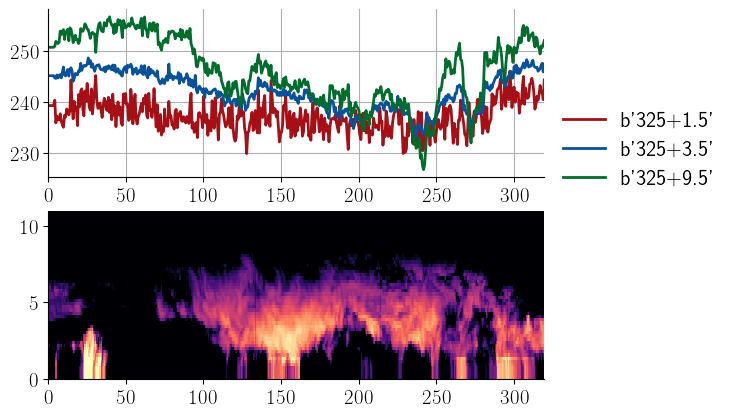

In [20]:
data = [
    tbs_ismar[:, 7],
    tbs_ismar[:, 8],
    tbs_ismar[:, 9],
]
names = map(lambda x: x.data, ISMAR.channel[7:10])
plot_channels(data, names)

In [21]:
y_ismar[:, 6:9] = tbs_ismar[:, 7:10]
y_ismar_nedt[:, 6:9] = errors_ismar[:, 7:10]

### 664 GHz

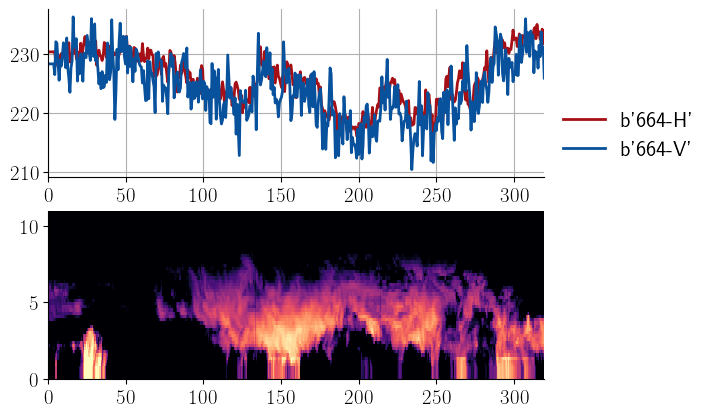

In [22]:
data = [
    tbs_ismar[:, 17],
    tbs_ismar[:, 18],
]
names = map(lambda x: x.data, ISMAR.channel[17:19])
plot_channels(data, names)

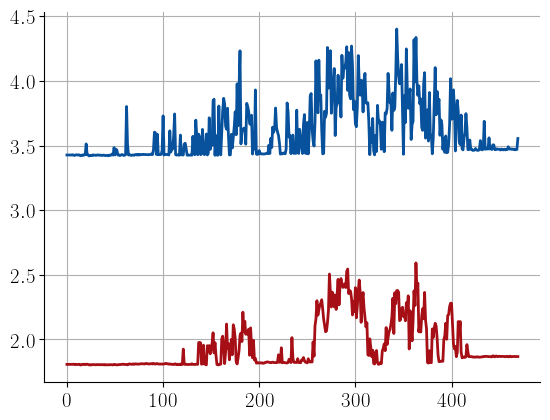

In [23]:
plt.plot(errors_ismar[:, 17])
plt.plot(errors_ismar[:, 18])
plt.show()

In [24]:
y_ismar[:, 9] = 0.5 * (tbs_ismar[:, 17] + tbs_ismar[:, 18])
y_ismar_nedt[:, 9] = np.sqrt(0.5 * (errors_ismar[:, 17] ** 2 + errors_ismar[:, 18] ** 2))

In [26]:
import xarray as xr
input_data = {
    # Atmosphere
    "latitude": (("rays",), RADAR.latitude.data),
    "longitude": (("rays",), RADAR.longitude.data),
    "altitude": (("rays", "levels",), np.broadcast_to(RADAR.height.data.reshape(1, -1),
                                                      RADAR.dbz.shape)),
    "pressure": (("rays", "levels"), ATMOSPHERE.pressure.data),
    "temperature": (("rays", "levels"), ATMOSPHERE.temperature.data),
    "cloud_water": (("rays", "levels"), ATMOSPHERE.cloud_water.data),
    #"H2O": (("rays", "levels"), ATMOSPHERE.relative_humidity),
    "H2O": (("rays", "levels"), ATMOSPHERE.water_vapor.data),
    "H2O_xa": (("rays", "levels"), ATMOSPHERE.relative_humidity.data),
    "O2": (("rays", "levels"), ATMOSPHERE.oxygen.data),
    "O3": (("rays", "levels"), ATMOSPHERE.ozone.data),
    "N2": (("rays", "levels"), ATMOSPHERE.nitrogen.data),
    # Surface variables
    "sea_surface_temperature": (("rays",), ATMOSPHERE.sea_surface_temperature.data),
    "wind_u": (("rays",), ATMOSPHERE.u10.data),
    "wind_v": (("rays",), ATMOSPHERE.v10.data),
    "surface_wind_speed": (("rays",
                            np.sqrt(ATMOSPHERE.u10.data ** 2 +
                                    ATMOSPHERE.v10.data ** 2))),
    # Observations
    "y_hamp_radar": (("rays", "range_bins"), RADAR.dbz.data),
    "y_hamp_radar_nedt": (("rays", "range_bins"), 0.5 * np.ones_like(RADAR.dbz) + RADAR.nedt.data),
    "hamp_radar_range_bins": (("rays", "range_bin_boundaries"), 
                              np.broadcast_to(RADAR.range_bins.data.reshape(1, -1),
                                              (RADAR.dbz.shape[0], RADAR.dbz.shape[1] + 1))),
    "hamp_radar_sensor_pos": (("rays",), RADAR.range_bins.data[-1] * np.ones(RADAR.dbz.data.shape[0])),
    "y_marss": (("rays", "marss_channels"), y_marss),
    "y_marss_nedt": (("rays", "marss_channels"), y_marss_nedt),
    "marss_sensor_position": (("rays",), MARSS.altitude.data),
    "marss_sensor_line_of_sight": (("rays",), 180 * np.ones(MARSS.altitude.size)),
    "y_ismar": (("rays", "ismar_channels"), y_ismar),
    "y_ismar_nedt": (("rays", "ismar_channels"), y_ismar_nedt),
    "ismar_sensor_position": (("rays",), ISMAR.altitude.data),
    "ismar_sensor_line_of_sight": (("rays",), 180 * np.ones(ISMAR.altitude.size))
}
dataset = xr.Dataset(input_data)
dataset.to_netcdf("../data/input_b984.nc")
dataset.close()